In [1]:
import pandas as pd
import numpy as np
import json
import math
import re
import sys
import holoviews as hv
hv.extension('bokeh')

# Leitura dos csvs

In [2]:
acidents_data = pd.read_csv('data/acidentes-2016.csv', sep=';')

In [3]:
ender_semaf = pd.read_excel('data/semaforos.xlsx')

In [4]:
eletronic_spine = pd.read_excel('data/lombadas.xls', header=None, names=['Endereco_detalhado'])

In [5]:
sparrow = pd.read_excel('data/pardais.xls')

In [6]:
bike_path = pd.read_csv('data/cicloviasimplantadas.csv', sep=';')

# Tratamento dos dados

#### Transformando colunas LOCAL, TIPO_ACID E REGIAO em categóricos

In [7]:
acidents_data['LOCAL'] = acidents_data['LOCAL'].astype('category') # Cruzamento ou Logradouro
acidents_data['TIPO_ACID'] = acidents_data['TIPO_ACID'].astype('category') # ATROPELAMENTO, ABALROAMENTO, CHOQUE, COLISAO
acidents_data['REGIAO'] = acidents_data['REGIAO'].astype('category') # Sul, Leste, Centro, Norte, Oeste

Pegar o mês referente ao número do csv no campo MES

In [8]:
def numberToMonth(number):
    month = {1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho', 7: 'Julho', 
         8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}
    return month[number]

In [9]:
acidents_data['MES'] = acidents_data['MES'].apply(lambda number: numberToMonth(number))
acidents_data['MES'].head(5)

0    Janeiro
1    Janeiro
2    Janeiro
3    Janeiro
4    Janeiro
Name: MES, dtype: object

Pegar somente a hora do acidente

In [10]:
def getHour(h):
    if h is not np.nan:
        return re.match(r'(.*):.*', h).groups()[0]
    else:
        return np.nan
acidents_data['HORA_ACID'] = acidents_data['HORA'].apply(lambda hour: getHour(hour))
acidents_data['HORA_ACID'].head(5)

0    14
1    16
2    16
3    05
4    12
Name: HORA_ACID, dtype: object

Metodo 'remove_accents' retira os acentos das letras, utilizado para retirar os acentos dos endereços para a tentativa de um possível casamento com os endereços do acidentes.
E leitura do dataset de semáforos separando os endereços dos cruzamentos em dois endereços separados em Log1 e Log2.

In [11]:
def remove_accents(word):
    word = word.lower()
    word = word.replace('ç','c')
    word = word.replace('ó','o')
    word = word.replace('ô','o')
    word = word.replace('ò','o')
    word = word.replace('õ','o')
    word = word.replace('á','a')
    word = word.replace('à','a')
    word = word.replace('â','a')
    word = word.replace('ã','a')
    word = word.replace('é','e')
    word = word.replace('è','e')
    word = word.replace('ê','e')
    word = word.replace('í','i')
    word = word.replace('ì','i')
    word = word.replace('ú','u')
    word = word.replace('ù','u')
    word = word.replace('ü','u')
    return word.upper()

In [12]:
ender_semaf['Log1'] = ender_semaf['Endereco'].apply(lambda x: remove_accents(re.match(r'(.*) X (.*)', x).groups()[0]))
ender_semaf['Log2'] = ender_semaf['Endereco'].apply(lambda x: remove_accents(re.match(r'(.*) X (.*)', x).groups()[1]))

In [14]:
def getNumberAdress(adress):
    number = re.search('\d+(?![\d+a-z])', adress)
    return number.group() if number is not None else np.nan

def fixAdress(adress):
    invalidWord = ['entre', 'defronte', 'nro', 'corredor']
    fix = adress.split(' ')
    rightAdress = ''
    for word in fix:
        if word.lower() in invalidWord or len(word) == 1:
            break
        else:
            rightAdress += word + ' '
    return rightAdress[:-1]

In [15]:
eletronic_spine['Endereco'] = eletronic_spine['Endereco_detalhado'].apply(lambda x: fixAdress(re.sub('[\d+]', '', x)))
eletronic_spine['Numero'] = eletronic_spine['Endereco_detalhado'].apply(lambda x: getNumberAdress(x))
eletronic_spine.head()

,Endereco_detalhado,Endereco,Numero
0,Av. Antônio de Carvalho 1655,Av. Antônio de Carvalho,1655
1,Av. Antônio de Carvalho entre 1800 e 1820,Av. Antônio de Carvalho,1800
2,Antônio de Carvalho 2320,Antônio de Carvalho,2320
3,Av. Antônio de Carvalho a 10m do nro 2079 -,Av. Antônio de Carvalho,2079
4,Mal. José Inácio da Silva a 14 5m da Rua Nova ...,Mal. José Inácio da Silva,14


In [16]:
sparrow['Endereco'] = sparrow['Logradouro'].apply(lambda x: fixAdress(re.sub('[\d+]', '', x)))
sparrow['Numero'] = sparrow['Logradouro'].apply(lambda x: getNumberAdress(x))
sparrow.head()

,Logradouro,Endereco,Numero
0,Av. Assis Brasil 4935,Av. Assis Brasil,4935
1,Av. Assis Brasil defronte 4945,Av. Assis Brasil,4945
2,Av. Assis Brasil 8207,Av. Assis Brasil,8207
3,Av. Assis Brasil 8292,Av. Assis Brasil,8292
4,Av. Bento Gonçalves 4021,Av. Bento Gonçalves,4021


In [17]:
#bike_path = bike_path.drop(columns=['geojson'])
bike_path.head()

,id,situacao,nome,geojson
0,1,CONCLUIDO,JOAO PESSOA,"{""type"":""MultiLineString"",""coordinates"":[[[-51..."
1,2,CONCLUIDO,JOAO ANTONIO SILVEIRA,"{""type"":""MultiLineString"",""coordinates"":[[[-51..."
2,3,CONCLUIDO,JOAO ANTONIO SILVEIRA,"{""type"":""MultiLineString"",""coordinates"":[[[-51..."
3,4,CONCLUIDO,JOAO ANTONIO SILVEIRA,"{""type"":""MultiLineString"",""coordinates"":[[[-51..."
4,5,CONCLUIDO,JOAO ANTONIO SILVEIRA,"{""type"":""MultiLineString"",""coordinates"":[[[-51..."


Calcular distância entre linha e ponto. Entre dois pontos. E Entre multi-linhas e um ponto.

In [18]:
def norm(value):
    if(value>=1.0):
        return 1.0
    if(value<=-1.0):
        return -1.0
    return value

def dis(latA, lonA, latB, lonB):
    R = 6371000
    d = math.acos(norm( math.sin(latA)* math.sin(latB) + math.cos(latA)*math.cos(latB)*math.cos(lonB-lonA) )) * R
    return d

def bear( latA,lonA,latB,lonB ):
    b = math.atan2( math.sin(lonB-lonA)*math.cos(latB) , math.cos(latA)*math.sin(latB) - math.sin(latA)*math.cos(latB)*math.cos(lonB-lonA) )
    return b

def crossarc(lat1,lon1,lat2,lon2,lat3,lon3):
    lat1= math.radians(lat1) 
    lat2= math.radians(lat2)
    lat3= math.radians(lat3)
    lon1= math.radians(lon1)
    lon2= math.radians(lon2)
    lon3= math.radians(lon3)

    R=6371000
    
    bear12 = bear(lat1,lon1,lat2,lon2)
    bear13 = bear(lat1,lon1,lat3,lon3)
    dis13 = dis(lat1,lon1,lat3,lon3)
    dxa = 0.0
    if math.fabs(bear13-bear12)>(math.pi/2):
        dxa = dis13
    else:
        dxt = math.asin( math.sin(dis13/R)* math.sin(bear13 - bear12) ) * R
        dis12 = dis(lat1,lon1,lat2,lon2);
        dis14 = math.acos(math.cos(dis13/R) / math.cos(dxt/R) ) * R;
        if dis14>dis12:
            dxa=dis(lat2,lon2,lat3,lon3);
        else:
            dxa=math.fabs(dxt);
    return dxa

def dist_line_point(lat_l1, lon_l1, lat_l2, lon_l2, lat_p, lon_p):
    return crossarc(lat_l1, lon_l1, lat_l2, lon_l2, lat_p, lon_p)

def dist_point_point(lat_p1, lon_p1, lat_p2, lon_p2):
    return crossarc(lat_p1, lon_p1, lat_p1, lon_p1, lat_p2, lon_p2)

def dist_multiline_point(ciclovia, lat_p, lon_p):
    ciclovia = ciclovia[0]
    dist = sys.float_info.max
    index = 0
    while index < (len(ciclovia)-1):
        dist = min(dist,dist_line_point(ciclovia[index][1],ciclovia[index][0],ciclovia[index+1][1],ciclovia[index+1][0],lat_p,lon_p))
        index += 1
    return dist

In [20]:
print(crossarc(-30.085209000000003,-51.233864000000004,-30.085209000000003,-51.233864000000004,-30.0669677,-51.1925572))

4462.3259236570975


Carregando os dados dos Semafóros, Pardais e Lombadas com latitudes e longitudes que foram calculadas utilizando o Google Geocoding API no Google Sheets. 
Também fizemos os seguintes calculos:
-> Para cada acidente contamos o número de semáforos, pardais e lombadas eletronicas até 10m, 20m, 50m, 100m e 200m;
-> Para cada acidente que envolve uma bicicleta, contamos o número de ciclovias próximas até 10m, 20m, 50, 100m e 200m;
-> Para cada pardal e lombada eletronica contamos o número de acidentes que aconteceram até 10m, 20m, 50m, 100m e 200m;
-> Para cada ciclovia contamos o número de acidentes envolvendo uma bicicleta até 10m, 20m, 50m, 100m, 200m.

Esse código será comentado, pois vamos consertar para que contem só os acidentes que aconteceram na mesma rua do pardal e das lombadas nas mesmas distâncias descritas acima. No caso das ciclovias, não terá como ser feito, pois não temos o endereço delas. E dos semafóros também não será possivel pois o dataset está bem não padronizado e pelo tamanho, não dá pra fazer um mapeamento a mão como fizemos com pardais e lombadas. Então, em ciclovias e semafóros iremos pegar todos os acidentes considerando o raio. Já em relação a pardais e lombadas, vamos considerar apenas os acidentes que acontecem na mesma via.

In [21]:
'''
pardais = pd.read_csv('src/data/pardaisAux.csv', sep=',')
semaforos = pd.read_csv('src/data/semaforosAux.csv', sep=',')
lombadas = pd.read_csv('src/data/lombadasAux.csv', sep=',')
acidents_data["semaforos_10m"] = 0
acidents_data["semaforos_20m"] = 0
acidents_data["semaforos_50m"] = 0
acidents_data["semaforos_100m"] = 0
acidents_data["semaforos_200m"] = 0
acidents_data["semaforos_500m"] = 0
acidents_data["semaforos_1000m"] = 0
acidents_data["pardais_10m"] = 0
acidents_data["pardais_20m"] = 0
acidents_data["pardais_50m"] = 0
acidents_data["pardais_100m"] = 0
acidents_data["pardais_200m"] = 0
acidents_data["pardais_500m"] = 0
acidents_data["pardais_1000m"] = 0
acidents_data["lombadas_10m"] = 0
acidents_data["lombadas_20m"] = 0
acidents_data["lombadas_50m"] = 0
acidents_data["lombadas_100m"] = 0
acidents_data["lombadas_200m"] = 0
acidents_data["lombadas_500m"] = 0
acidents_data["lombadas_1000m"] = 0
acidents_data["ciclovias_10m"] = 0
acidents_data["ciclovias_20m"] = 0
acidents_data["ciclovias_50m"] = 0
acidents_data["ciclovias_100m"] = 0
acidents_data["ciclovias_200m"] = 0
acidents_data["ciclovias_500m"] = 0
acidents_data["ciclovias_1000m"] = 0
lombadas["acidentes_10m"] = 0
lombadas["acidentes_20m"] = 0
lombadas["acidentes_50m"] = 0
lombadas["acidentes_100m"] = 0
lombadas["acidentes_200m"] = 0
lombadas["acidentes_500m"] = 0
lombadas["acidentes_1000m"] = 0
pardais["acidentes_10m"] = 0
pardais["acidentes_20m"] = 0
pardais["acidentes_50m"] = 0
pardais["acidentes_100m"] = 0
pardais["acidentes_200m"] = 0
pardais["acidentes_500m"] = 0
pardais["acidentes_1000m"] = 0
bike_path["acidentes_10m"] = 0
bike_path["acidentes_20m"] = 0
bike_path["acidentes_50m"] = 0
bike_path["acidentes_100m"] = 0
bike_path["acidentes_200m"] = 0
bike_path["acidentes_500m"] = 0
bike_path["acidentes_1000m"] = 0
for indexA, rowA in acidents_data.iterrows():
    if(indexA%100==0):
        print(indexA)
    while(acidents_data.at[indexA,'LONGITUDE'] < -100.0):
        acidents_data.at[indexA,'LONGITUDE'] /= 10.0
    while(acidents_data.at[indexA,'LATITUDE'] < -100.0):
        acidents_data.at[indexA,'LATITUDE'] /= 10.0
    for indexS, rowS in semaforos.iterrows():
        dist = dist_point_point(rowA.LATITUDE, rowA.LONGITUDE, float(rowS.Lat.replace(',','.')), float(rowS.Lng.replace(',','.')))
        if(dist<=10.0):
            acidents_data.at[indexA,'semaforos_10m'] += 1
        if(dist<=20.0):
            acidents_data.at[indexA,'semaforos_20m'] +=  1
        if(dist<=50.0):
            acidents_data.at[indexA,'semaforos_50m'] += 1
        if(dist<=100.0):
            acidents_data.at[indexA,'semaforos_100m'] += 1
        if(dist<=200.0):
            acidents_data.at[indexA,'semaforos_200m'] += 1
        if(dist<=500.0):
            acidents_data.at[indexA,'semaforos_500m'] += 1
        if(dist<=1000.0):
            acidents_data.at[indexA,'semaforos_1000m'] += 1
    for indexP, rowP in pardais.iterrows():
        dist = dist_point_point(rowA.LATITUDE, rowA.LONGITUDE, rowP.Lat, rowP.Lng)
        if(dist<=10.0):
            acidents_data.at[indexA,'pardais_10m'] += 1
            pardais.at[indexP,"acidentes_10m"] += 1
        if(dist<=20.0):
            acidents_data.at[indexA,'pardais_20m'] +=  1
            pardais.at[indexP,"acidentes_20m"] += 1
        if(dist<=50.0):
            acidents_data.at[indexA,'pardais_50m'] += 1
            pardais.at[indexP,"acidentes_50m"] += 1
        if(dist<=100.0):
            acidents_data.at[indexA,'pardais_100m'] += 1
            pardais.at[indexP,"acidentes_100m"] += 1
        if(dist<=200.0):
            acidents_data.at[indexA,'pardais_200m'] += 1
            pardais.at[indexP,"acidentes_200m"] += 1
        if(dist<=500.0):
            acidents_data.at[indexA,'pardais_500m'] += 1
            pardais.at[indexP,"acidentes_500m"] += 1
        if(dist<=1000.0):
            acidents_data.at[indexA,'pardais_1000m'] += 1
            pardais.at[indexP,"acidentes_1000m"] += 1
    for indexL, rowL in lombadas.iterrows():
        dist = dist_point_point(rowA.LATITUDE, rowA.LONGITUDE, rowL.Lat, rowL.Lng)
        if(dist<=10.0):
            acidents_data.at[indexA,'lombadas_10m'] += 1
            lombadas.at[indexL,"acidentes_10m"] += 1
        if(dist<=20.0):
            acidents_data.at[indexA,'lombadas_20m'] +=  1
            lombadas.at[indexL,"acidentes_20m"] += 1
        if(dist<=50.0):
            acidents_data.at[indexA,'lombadas_50m'] += 1
            lombadas.at[indexL,"acidentes_50m"] += 1
        if(dist<=100.0):
            acidents_data.at[indexA,'lombadas_100m'] += 1
            lombadas.at[indexL,"acidentes_100m"] += 1
        if(dist<=200.0):
            acidents_data.at[indexA,'lombadas_200m'] += 1
            lombadas.at[indexL,"acidentes_200m"] += 1
        if(dist<=500.0):
            acidents_data.at[indexA,'lombadas_500m'] += 1
            lombadas.at[indexL,"acidentes_500m"] += 1
        if(dist<=1000.0):
            acidents_data.at[indexA,'lombadas_1000m'] += 1
            lombadas.at[indexL,"acidentes_1000m"] += 1
    if(rowA.BICICLETA > 0):
        for indexC, rowC in bike_path.iterrows():
            dist = dist_multiline_point(json.loads(rowC.geojson)["coordinates"], rowA.LATITUDE, rowA.LONGITUDE)
            if(dist<=10.0):
                acidents_data.at[indexA,'ciclovias_10m'] += 1
                bike_path.at[indexC,"acidentes_10m"] += 1
            if(dist<=20.0):
                acidents_data.at[indexA,'ciclovias_20m'] +=  1
                bike_path.at[indexC,"acidentes_20m"] += 1
            if(dist<=50.0):
                acidents_data.at[indexA,'ciclovias_50m'] += 1
                bike_path.at[indexC,"acidentes_50m"] += 1
            if(dist<=100.0):
                acidents_data.at[indexA,'ciclovias_100m'] += 1
                bike_path.at[indexC,"acidentes_100m"] += 1
            if(dist<=200.0):
                acidents_data.at[indexA,'ciclovias_200m'] += 1
                bike_path.at[indexC,"acidentes_200m"] += 1
            if(dist<=500.0):
                acidents_data.at[indexA,'ciclovias_500m'] += 1
                bike_path.at[indexC,"acidentes_500m"] += 1
            if(dist<=1000.0):
                acidents_data.at[indexA,'ciclovias_1000m'] += 1
                bike_path.at[indexC,"acidentes_1000m"] += 1

pd.options.display.max_columns = None
bike_path.to_csv('data/cicloviasDist.csv', sep=',', index = False)
lombadas.to_csv('data/lombadasDist.csv', sep=',', index = False)
pardais.to_csv('data/pardaisDist.csv', sep=',', index = False)
acidents_data.to_csv('data/AcidentesDist.csv', sep=',', index = False)
acidents_dat
'''

'\npardais = pd.read_csv(\'src/data/pardaisAux.csv\', sep=\',\')\nsemaforos = pd.read_csv(\'src/data/semaforosAux.csv\', sep=\',\')\nlombadas = pd.read_csv(\'src/data/lombadasAux.csv\', sep=\',\')\nacidents_data["semaforos_10m"] = 0\nacidents_data["semaforos_20m"] = 0\nacidents_data["semaforos_50m"] = 0\nacidents_data["semaforos_100m"] = 0\nacidents_data["semaforos_200m"] = 0\nacidents_data["semaforos_500m"] = 0\nacidents_data["semaforos_1000m"] = 0\nacidents_data["pardais_10m"] = 0\nacidents_data["pardais_20m"] = 0\nacidents_data["pardais_50m"] = 0\nacidents_data["pardais_100m"] = 0\nacidents_data["pardais_200m"] = 0\nacidents_data["pardais_500m"] = 0\nacidents_data["pardais_1000m"] = 0\nacidents_data["lombadas_10m"] = 0\nacidents_data["lombadas_20m"] = 0\nacidents_data["lombadas_50m"] = 0\nacidents_data["lombadas_100m"] = 0\nacidents_data["lombadas_200m"] = 0\nacidents_data["lombadas_500m"] = 0\nacidents_data["lombadas_1000m"] = 0\nacidents_data["ciclovias_10m"] = 0\nacidents_data["c

Aqui vamos tentar fazer um mapeamento para tentar mostrar quais ruas/avenidas possuem ou não pardais ou lombadas eletrônicas para saber se o fato de uma rua ter ou não algum desses equipamentos influencia ou não no n de vitimas.
Como eram poucos pardais e lombadas e o log1 e log2 estarem bem padronizados, fizemos um dict para descrever quantos equipamentos de fiscalização tinham em cada rua.
Depois fizemos um dict pa

In [22]:
dict_pardais = {
    "AV ASSIS BRASIL" : 4,
    "AV BENTO GONCALVES" : 7,
    "AV DA CAVALHADA" : 3,
    "AV DANTE ANGELO PILLA" : 1,
    "AV DR NILO PECANHA"  : 6,
    "AV EDGAR PIRES DE CASTRO" : 2,
    "AV EDUARDO PRADO" : 2,
    "AV IPIRANGA": 3,
    "ESTR JOAO DE OLIVEIRA REMIAO" : 2,
    "AV JUCA BATISTA" : 4,
    "AV MANOEL ELIAS" : 3,
    "AV NONOAI" : 1,
    "AV PADRE CACIQUE" : 1,
    "AV PRESIDENTE CASTELO BRANCO" : 2,
    "AV PROTASIO ALVES" : 4,
    "AV SENADOR TARSO DUTRA" : 1,
    "AV WENCESLAU ESCOBAR" : 1,
    "R SILVA SO" : 2,
    "AV EDVALDO PEREIRA PAIVA" : 2
}

dict_lombadas = {
    "AV ANTONIO CARVALHO" : 4,
    "R MARECHAL JOSE INACIO DA SILVA" : 2,
    "ESTR COSTA GAMA" : 2,
    "R DR OTAVIO SANTOS" : 2,
    "AV ICARAI" : 2,
    "R GUADALAJARA" : 2,
    "AV PADRE CACIQUE" : 4,
    "ESTR CRISTIANO KRAEMER" : 2,
    "AV SARTURINO DE BRITO" : 2,
    "AV PROF OSCAR PEREIRA": 2,
    "AV BALTAZAR DE OLIVEIRA GARCIA" : 2,
    "R TEN ARY TARRAGO PARTENON" : 2,
    "ESTR JOAO DE OLIVEIRA REMIAO" : 2,
    "R PAUL HARRIS" : 2,
    "AV JUCA BATISTA" : 1,
    "R VOLUNTARIOS DA PATRIA" : 2,
    "AV PADRE LEOPOLDO BRENTANO" : 1
}

dict_pardais2 = {
    "Av. Assis Brasil  4935 , Porto Alegre, RS, Brasil" : "AV ASSIS BRASIL",
    "Av. Assis Brasil 4945 , Porto Alegre, RS, Brasil" : "AV ASSIS BRASIL",
    "Av. Assis Brasil  8207 , Porto Alegre, RS, Brasil" : "AV ASSIS BRASIL",
    "Av. Assis Brasil  8292 , Porto Alegre, RS, Brasil" : "AV ASSIS BRASIL",
    "Av. Bento Gonçalves  4021 , Porto Alegre, RS, Brasil" : "AV BENTO GONCALVES",
    "Av. Bento Gonçalves  6963 , Porto Alegre, RS, Brasil" : "AV BENTO GONCALVES",
    "Av. Bento Gonçalves  6992 , Porto Alegre, RS, Brasil" : "AV BENTO GONCALVES",
    "Av. Bento Gonçalves  8083 , Porto Alegre, RS, Brasil" : "AV BENTO GONCALVES",
    "Av. Bento Gonçalves 8083 , Porto Alegre, RS, Brasil" : "AV BENTO GONCALVES",
    "Av. Bento Gonçalves  9519 , Porto Alegre, RS, Brasil" : "AV BENTO GONCALVES",
    "Av. Bento Gonçalves 9535 , Porto Alegre, RS, Brasil" : "AV BENTO GONCALVES",
    "Av. Cavalhada  3696 , Porto Alegre, RS, Brasil" : "AV DA CAVALHADA",
    "Av. Cavalhada 4530 , Porto Alegre, RS, Brasil" : "AV DA CAVALHADA",
    "Av. Cavalhada 4414 , Porto Alegre, RS, Brasil" : "AV DA CAVALHADA",
    "Av. Dante Angelo Pilla  373 , Porto Alegre, RS, Brasil" : "AV DANTE ANGELO PILLA",
    "Av. Dr. Nilo Peçanha 350 , Porto Alegre, RS, Brasil" : "AV DR NILO PECANHA",
    "Av. Dr. Nilo Peçanha  350 , Porto Alegre, RS, Brasil" : "AV DR NILO PECANHA",
    "Av. Dr. Nilo Peçanha  2122 , Porto Alegre, RS, Brasil" : "AV DR NILO PECANHA",
    "Av. Dr. Nilo Peçanha 2122 , Porto Alegre, RS, Brasil" : "AV DR NILO PECANHA",
    "Av. Dr. Nilo Peçanha  2715 , Porto Alegre, RS, Brasil" : "AV DR NILO PECANHA",
    "Av. Dr. Nilo Peçanha  2690 , Porto Alegre, RS, Brasil" : "AV DR NILO PECANHA",
    "Av. Edgar Pires de Castro  9331 , Porto Alegre, RS, Brasil" : "AV EDGAR PIRES DE CASTRO",
    "Av. Edgar Pires de Castro DF  9349 , Porto Alegre, RS, Brasil" : "AV EDGAR PIRES DE CASTRO",
    "Av. Eduardo Prado  1370 , Porto Alegre, RS, Brasil" : "AV EDUARDO PRADO",
    "Av. Eduardo Prado 1270 , Porto Alegre, RS, Brasil" : "AV EDUARDO PRADO",
    "Av. Ipiranga 2860 , Porto Alegre, RS, Brasil" : "AV IPIRANGA",
    "Av. Ipiranga 8185 , Porto Alegre, RS, Brasil" : "AV IPIRANGA",
    "Av. Ipiranga 8185 , Porto Alegre, RS, Brasil" : "AV IPIRANGA",
    "Av. João de Oliveira Remião,  5989 , Porto Alegre, RS, Brasil" : "ESTR JOAO DE OLIVEIRA REMIAO",
    "Av. João de Oliveira Remião,  5740 , Porto Alegre, RS, Brasil" : "ESTR JOAO DE OLIVEIRA REMIAO",
    "Av. Juca Batista 2918 , Porto Alegre, RS, Brasil" : "AV JUCA BATISTA",
    "Av. Juca Batista 3378 , Porto Alegre, RS, Brasil" : "AV JUCA BATISTA",
    "Av. Juca Batista 8455 , Porto Alegre, RS, Brasil" : "AV JUCA BATISTA",
    "Av. Juca Batista 8455 , Porto Alegre, RS, Brasil" : "AV JUCA BATISTA",
    "Av. Manoel Elias  768 , Porto Alegre, RS, Brasil" : "AV MANOEL ELIAS",
    "Av. Manoel Elias  1790 , Porto Alegre, RS, Brasil" : "AV MANOEL ELIAS",
    "Av. Manoel Elias 1800 , Porto Alegre, RS, Brasil" : "AV MANOEL ELIAS",
    "Av. Nonoai  849 , Porto Alegre, RS, Brasil" : "AV NONOAI",
    "Av. Padre Cacique 1804 , Porto Alegre, RS, Brasil" : "AV PADRE CACIQUE",
    "Av. Pres.Castelo Branco I/C  , Porto Alegre, RS, Brasil" : "AV PRESIDENTE CASTELO BRANCO",
    "Av. Pres. Castelo Branco Km  C/I 1 , Porto Alegre, RS, Brasil" : "AV PRESIDENTE CASTELO BRANCO",
    "Av. Protasio Alves 7777 , Porto Alegre, RS, Brasil" : "AV PROTASIO ALVES",
    "Av. Protasio Alves  7777 , Porto Alegre, RS, Brasil" : "AV PROTASIO ALVES",
    "Av. Protasio Alves 10564 , Porto Alegre, RS, Brasil" : "AV PROTASIO ALVES",
    "Av. Protasio Alves 10835 , Porto Alegre, RS, Brasil" : "AV PROTASIO ALVES",
    "Av. Senador Tarso Dutra N/S  , Porto Alegre, RS, Brasil" : "AV SENADOR TARSO DUTRA",
    "Av. Wenceslau Escobar 1657 , Porto Alegre, RS, Brasil" : "AV WENCESLAU ESCOBAR",
    "Rua Silva Só  280 , Porto Alegre, RS, Brasil" : "R SILVA SO",
    "Rua Silva Só  269 , Porto Alegre, RS, Brasil" : "R SILVA SO",
    "Edvaldo Pereira Paiva  , Porto Alegre, RS, Brasil" : "AV EDVALDO PEREIRA PAIVA",
    "Edvaldo Pereira Paiva  , Porto Alegre, RS, Brasil" : "AV EDVALDO PEREIRA PAIVA"
}

dict_lombadas2 = {
    "Av. Antônio de Carvalho  1655 , Porto Alegre, RS, Brasil" : "AV ANTONIO CARVALHO",
    "Av. Antônio de Carvalho 1800 , Porto Alegre, RS, Brasil" : "AV ANTONIO CARVALHO",
    "Antônio de Carvalho  2320 , Porto Alegre, RS, Brasil" : "AV ANTONIO CARVALHO",
    "Av. Antônio de Carvalho 2079 , Porto Alegre, RS, Brasil" : "AV ANTONIO CARVALHO",
    "Mal. José Inácio da Silva 14 , Porto Alegre, RS, Brasil" : "R MARECHAL JOSE INACIO DA SILVA",
    "Mal. José Inácio da Silva 240 , Porto Alegre, RS, Brasil" : "R MARECHAL JOSE INACIO DA SILVA",
    "Estrada Costa Gama 3501 , Porto Alegre, RS, Brasil" : "ESTR COSTA GAMA",
    "Estrada Costa Gama  3501 , Porto Alegre, RS, Brasil" : "ESTR COSTA GAMA",
    "Rua Dr. Otávio Santos  330 , Porto Alegre, RS, Brasil" : "R DR OTAVIO SANTOS",
    "Rua Dr. Otávio Santos  257 , Porto Alegre, RS, Brasil" : "R DR OTAVIO SANTOS",
    "Av. Icaraí  1719 , Porto Alegre, RS, Brasil" : "AV ICARAI",
    "Av. Icaraí 1949 , Porto Alegre, RS, Brasil" : "AV ICARAI",
    "Rua Guadalajara  1035 , Porto Alegre, RS, Brasil" : "R GUADALAJARA",
    "Rua Guadalajara  , Porto Alegre, RS, Brasil" : "R GUADALAJARA",
    "Av. Padre Cacique  1178 , Porto Alegre, RS, Brasil" : "AV PADRE CACIQUE",
    "Av. Padre Cacique  1178 , Porto Alegre, RS, Brasil" : "AV PADRE CACIQUE",
    "Estrada Cristiano Kraemer  1771 , Porto Alegre, RS, Brasil" : "ESTR CRISTIANO KRAEMER",
    "Estrada Cristiano Kraemer 1621 , Porto Alegre, RS, Brasil" : "ESTR CRISTIANO KRAEMER",
    "Saturnino de Brito 1400 , Porto Alegre, RS, Brasil" : "AV SARTURINO DE BRITO",
    "Saturnino de Brito  1400 , Porto Alegre, RS, Brasil" : "AV SARTURINO DE BRITO",
    "Av. Oscar Pereira  4445 , Porto Alegre, RS, Brasil" : "AV PROF OSCAR PEREIRA",
    "Av. Oscar Pereira  4464 , Porto Alegre, RS, Brasil" : "AV PROF OSCAR PEREIRA",
    "Av. Baltazar de Oliveira Garcia  1981 , Porto Alegre, RS, Brasil" : "AV BALTAZAR DE OLIVEIRA GARCIA",
    "Av. Baltazar de Oliveira Garcia  1956 , Porto Alegre, RS, Brasil" : "AV BALTAZAR DE OLIVEIRA GARCIA",
    "Rua Ten. Ary Tarrago  285 , Porto Alegre, RS, Brasil" : "R TEN ARY TARRAGO PARTENON",
    "Rua Ten. Ary Tarragô 293 , Porto Alegre, RS, Brasil" : "R TEN ARY TARRAGO PARTENON" ,
    "Av. Joao de Oliveira Remiao 6500 , Porto Alegre, RS, Brasil" : "ESTR JOAO DE OLIVEIRA REMIAO",
    "Av. Joao de Oliveira Remiao 6609 , Porto Alegre, RS, Brasil" : "ESTR JOAO DE OLIVEIRA REMIAO",
    "Rua Paul Harris 467 , Porto Alegre, RS, Brasil" : "R PAUL HARRIS",
    "Rua Paul Harris  415 , Porto Alegre, RS, Brasil" : "R PAUL HARRIS",
    "Juca Batista  3156 , Porto Alegre, RS, Brasil" : "AV JUCA BATISTA",
    "Av. Juca Batista  3151 , Porto Alegre, RS, Brasil" :"AV JUCA BATISTA",
    "Voluntários da Pátria  1819 , Porto Alegre, RS, Brasil" : "R VOLUNTARIOS DA PATRIA",
    "Voluntários da Pátria 1981 , Porto Alegre, RS, Brasil" : "R VOLUNTARIOS DA PATRIA",
    "Av. Padre Leopoldo Brentano  O/L 423 , Porto Alegre, RS, Brasil" : "AV PADRE LEOPOLDO BRENTANO",
    "Padre Cacique  , Porto Alegre, RS, Brasil" : "AV PADRE CACIQUE",
    "Av. Padre Cacique  , Porto Alegre, RS, Brasil" : "AV PADRE CACIQUE"
}

In [23]:
pardais = pd.read_csv('src/data/pardaisAux.csv', sep=',')
semaforos = pd.read_csv('src/data/semaforosAux.csv', sep=',')
lombadas = pd.read_csv('src/data/lombadasAux.csv', sep=',')
acidents_data["semaforos_10m"] = 0
acidents_data["semaforos_20m"] = 0
acidents_data["semaforos_50m"] = 0
acidents_data["semaforos_100m"] = 0
acidents_data["semaforos_200m"] = 0
acidents_data["semaforos_500m"] = 0
acidents_data["semaforos_1000m"] = 0
acidents_data["pardais_10m"] = 0
acidents_data["pardais_20m"] = 0
acidents_data["pardais_50m"] = 0
acidents_data["pardais_100m"] = 0
acidents_data["pardais_200m"] = 0
acidents_data["pardais_500m"] = 0
acidents_data["pardais_1000m"] = 0
acidents_data["lombadas_10m"] = 0
acidents_data["lombadas_20m"] = 0
acidents_data["lombadas_50m"] = 0
acidents_data["lombadas_100m"] = 0
acidents_data["lombadas_200m"] = 0
acidents_data["lombadas_500m"] = 0
acidents_data["lombadas_1000m"] = 0
acidents_data["ciclovias_10m"] = 0
acidents_data["ciclovias_20m"] = 0
acidents_data["ciclovias_50m"] = 0
acidents_data["ciclovias_100m"] = 0
acidents_data["ciclovias_200m"] = 0
acidents_data["ciclovias_500m"] = 0
acidents_data["ciclovias_1000m"] = 0
lombadas["acidentes_10m"] = 0
lombadas["acidentes_20m"] = 0
lombadas["acidentes_50m"] = 0
lombadas["acidentes_100m"] = 0
lombadas["acidentes_200m"] = 0
lombadas["acidentes_500m"] = 0
lombadas["acidentes_1000m"] = 0
pardais["acidentes_10m"] = 0
pardais["acidentes_20m"] = 0
pardais["acidentes_50m"] = 0
pardais["acidentes_100m"] = 0
pardais["acidentes_200m"] = 0
pardais["acidentes_500m"] = 0
pardais["acidentes_1000m"] = 0
bike_path["acidentes_10m"] = 0
bike_path["acidentes_20m"] = 0
bike_path["acidentes_50m"] = 0
bike_path["acidentes_100m"] = 0
bike_path["acidentes_200m"] = 0
bike_path["acidentes_500m"] = 0
bike_path["acidentes_1000m"] = 0
for indexA, rowA in acidents_data.iterrows():
    if(indexA%100==0):
        print(indexA)
    while(acidents_data.at[indexA,'LONGITUDE'] < -100.0):
        acidents_data.at[indexA,'LONGITUDE'] /= 10.0
    while(acidents_data.at[indexA,'LATITUDE'] < -100.0):
        acidents_data.at[indexA,'LATITUDE'] /= 10.0
    for indexS, rowS in semaforos.iterrows():
        dist = dist_point_point(rowA.LATITUDE, rowA.LONGITUDE, float(rowS.Lat.replace(',','.')), float(rowS.Lng.replace(',','.')))
        if(dist<=10.0):
            acidents_data.at[indexA,'semaforos_10m'] += 1
        if(dist<=20.0):
            acidents_data.at[indexA,'semaforos_20m'] +=  1
        if(dist<=50.0):
            acidents_data.at[indexA,'semaforos_50m'] += 1
        if(dist<=100.0):
            acidents_data.at[indexA,'semaforos_100m'] += 1
        if(dist<=200.0):
            acidents_data.at[indexA,'semaforos_200m'] += 1
        if(dist<=500.0):
            acidents_data.at[indexA,'semaforos_500m'] += 1
        if(dist<=1000.0):
            acidents_data.at[indexA,'semaforos_1000m'] += 1
    for indexP, rowP in pardais.iterrows():
        dist = dist_point_point(rowA.LATITUDE, rowA.LONGITUDE, rowP.Lat, rowP.Lng)
        if(dist<=10.0 and (dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG1 or dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'pardais_10m'] += 1
            pardais.at[indexP,"acidentes_10m"] += 1
        if(dist<=20.0and (dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG1 or dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'pardais_20m'] +=  1
            pardais.at[indexP,"acidentes_20m"] += 1
        if(dist<=50.0 and (dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG1 or dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'pardais_50m'] += 1
            pardais.at[indexP,"acidentes_50m"] += 1
        if(dist<=100.0 and (dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG1 or dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'pardais_100m'] += 1
            pardais.at[indexP,"acidentes_100m"] += 1
        if(dist<=200.0 and (dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG1 or dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'pardais_200m'] += 1
            pardais.at[indexP,"acidentes_200m"] += 1
        if(dist<=500.0 and (dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG1 or dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'pardais_500m'] += 1
            pardais.at[indexP,"acidentes_500m"] += 1
        if(dist<=1000.0 and (dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG1 or dict_pardais2[rowP.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'pardais_1000m'] += 1
            pardais.at[indexP,"acidentes_1000m"] += 1
    for indexL, rowL in lombadas.iterrows():
        dist = dist_point_point(rowA.LATITUDE, rowA.LONGITUDE, rowL.Lat, rowL.Lng)
        if(dist<=10.0 and (dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG1 or dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'lombadas_10m'] += 1
            lombadas.at[indexL,"acidentes_10m"] += 1
        if(dist<=20.0 and (dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG1 or dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'lombadas_20m'] +=  1
            lombadas.at[indexL,"acidentes_20m"] += 1
        if(dist<=50.0 and (dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG1 or dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'lombadas_50m'] += 1
            lombadas.at[indexL,"acidentes_50m"] += 1
        if(dist<=100.0 and (dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG1 or dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'lombadas_100m'] += 1
            lombadas.at[indexL,"acidentes_100m"] += 1
        if(dist<=200.0 and (dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG1 or dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'lombadas_200m'] += 1
            lombadas.at[indexL,"acidentes_200m"] += 1
        if(dist<=500.0 and (dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG1 or dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'lombadas_500m'] += 1
            lombadas.at[indexL,"acidentes_500m"] += 1
        if(dist<=1000.0 and (dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG1 or dict_lombadas2[rowL.Endereco_detalhado] == rowA.LOG2)):
            acidents_data.at[indexA,'lombadas_1000m'] += 1
            lombadas.at[indexL,"acidentes_1000m"] += 1
    if(rowA.BICICLETA > 0):
        for indexC, rowC in bike_path.iterrows():
            dist = dist_multiline_point(json.loads(rowC.geojson)["coordinates"], rowA.LATITUDE, rowA.LONGITUDE)
            if(dist<=10.0):
                acidents_data.at[indexA,'ciclovias_10m'] += 1
                bike_path.at[indexC,"acidentes_10m"] += 1
            if(dist<=20.0):
                acidents_data.at[indexA,'ciclovias_20m'] +=  1
                bike_path.at[indexC,"acidentes_20m"] += 1
            if(dist<=50.0):
                acidents_data.at[indexA,'ciclovias_50m'] += 1
                bike_path.at[indexC,"acidentes_50m"] += 1
            if(dist<=100.0):
                acidents_data.at[indexA,'ciclovias_100m'] += 1
                bike_path.at[indexC,"acidentes_100m"] += 1
            if(dist<=200.0):
                acidents_data.at[indexA,'ciclovias_200m'] += 1
                bike_path.at[indexC,"acidentes_200m"] += 1
            if(dist<=500.0):
                acidents_data.at[indexA,'ciclovias_500m'] += 1
                bike_path.at[indexC,"acidentes_500m"] += 1
            if(dist<=1000.0):
                acidents_data.at[indexA,'ciclovias_1000m'] += 1
                bike_path.at[indexC,"acidentes_1000m"] += 1

pd.options.display.max_columns = None
bike_path.to_csv('data/cicloviasDist2.csv', sep=',', index = False)
lombadas.to_csv('data/lombadasDist2.csv', sep=',', index = False)
pardais.to_csv('data/pardaisDist2.csv', sep=',', index = False)
acidents_data.to_csv('data/AcidentesDist2.csv', sep=',', index = False)
acidents_data

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500


,ID,LONGITUDE,LATITUDE,LOG1,LOG2,PREDIAL1,LOCAL,TIPO_ACID,LOCAL_VIA,QUEDA_ARR,DATA,DATA_HORA,DIA_SEM,HORA,FERIDOS,FERIDOS_GR,MORTES,MORTE_POST,FATAIS,AUTO,TAXI,LOTACAO,ONIBUS_URB,ONIBUS_MET,ONIBUS_INT,CAMINHAO,MOTO,CARROCA,BICICLETA,OUTRO,TEMPO,NOITE_DIA,FONTE,BOLETIM,REGIAO,DIA,MES,ANO,FX_HORA,CONT_ACID,CONT_VIT,UPS,CONSORCIO,CORREDOR,HORA_ACID,semaforos_10m,semaforos_20m,semaforos_50m,semaforos_100m,semaforos_200m,semaforos_500m,semaforos_1000m,pardais_10m,pardais_20m,pardais_50m,pardais_100m,pardais_200m,pardais_500m,pardais_1000m,lombadas_10m,lombadas_20m,lombadas_50m,lombadas_100m,lombadas_200m,lombadas_500m,lombadas_1000m,ciclovias_10m,ciclovias_20m,ciclovias_50m,ciclovias_100m,ciclovias_200m,ciclovias_500m,ciclovias_1000m
0,623243,-51.233864,-30.085209,R ARAPEI,R COMANDAI,0,Cruzamento,ATROPELAMENTO,R ARAPEI & R COMANDAI,0,2016-01-01,2016-01-01T14:30:00,SEXTA-FEIRA,14:30,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,BOM,DIA,DEPTRAN,56416,SUL,1,Janeiro,2016,14.0,1,1,5,NaN,0,14,0,0,0,0,0,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,622413,-51.231947,-30.108313,R PADRE JOAO BATISTA REUS,R JOAO MORA,0,Cruzamento,ABALROAMENTO,R PADRE JOAO BATISTA REUS & R JOAO MORA,0,2016-01-01,2016-01-01T16:45:00,SEXTA-FEIRA,16:45,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,NUBLADO,DIA,EPTC,294286,SUL,1,Janeiro,2016,16.0,1,0,1,NaN,0,16,0,0,0,0,1,5,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,622460,-51.212026,-30.045868,AV DO LAMI,NaN,0,Logradouro,ATROPELAMENTO,AV DO LAMI,0,2016-01-01,2016-01-01T16:30:00,SEXTA-FEIRA,16:30,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,BOM,DIA,DEPTRAN,13316,CENTRO,1,Janeiro,2016,16.0,1,1,5,NaN,0,16,0,0,0,0,3,13,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,622540,-51.185614,-30.034456,AV DR NILO PECANHA,R CARLOS TREIN FILHO,0,Cruzamento,CHOQUE,AV DR NILO PECANHA & R CARLOS TREIN FILHO,0,2016-01-01,2016-01-01T05:45:00,SEXTA-FEIRA,05:45,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,BOM,NOITE,EPTC,291292,LESTE,1,Janeiro,2016,5.0,1,0,1,NaN,0,05,0,0,0,0,1,4,32,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,622181,-51.097360,-30.131425,ESTR JOAO DE OLIVEIRA REMIAO,NaN,8487,Logradouro,CHOQUE,8487 ESTR JOAO DE OLIVEIRA REMIAO,0,2016-01-01,2016-01-01T12:00:00,SEXTA-FEIRA,12:00,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,BOM,DIA,DEPTRAN,216,LESTE,1,Janeiro,2016,12.0,1,1,13,NaN,0,12,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,622232,-51.225022,-30.046900,AV IPIRANGA,NaN,320,Logradouro,COLISAO,320 AV IPIRANGA,0,2016-01-02,2016-01-02T15:35:00,SABADO,15:35,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,BOM,DIA,DDT,10031116,CENTRO,2,Janeiro,2016,15.0,1,0,1,NaN,0,15,0,0,0,0,1,18,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,622414,-51.221523,-30.059818,R JOSE DE ALENCAR,NaN,965,Logradouro,COLISAO,965 R JOSE DE ALENCAR,0,2016-01-02,2016-01-02T16:25:00,SABADO,16:25,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,NUBLADO,DIA,EPTC,288968,SUL,2,Janeiro,2016,16.0,1,0,1,NaN,0,16,0,0,1,1,2,9,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,622186,-51.218406,-30.045945,AV ERICO VERISSIMO,NaN,240,Logradouro,ABALROAMENTO,240 AV ERICO VERISSIMO,0,2016-01-02,2016-01-02T18:30:00,SABADO,18:30,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,BOM,NOITE,DEPTRAN,4616,CENTRO,2,Janeiro,2016,18.0,1,1,5,STS,0,18,0,0,0,2,3,13,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,622235,-51.215827,-30.043633,R GEN LIMA E SILVA,NaN,1445,Logradouro,COLISAO,1445 R GEN LIMA E SILVA,0,2016-01-02,2016-01-02T22:30:00,SABADO,22:30,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,BOM,NOITE,DDT,10038916,CENTRO,2,Janeiro,2016,22.0,1,0,1,NaN,0,22,0,0,0,1,3,21,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,622185,-51.200627,-30.004450,AV EDVALDO PEREIRA PAIVA,NaN,0,Logradouro,QUEDA,AV EDVALDO PEREIRA PAIVA,0,2016-01-02,2016-01-02T06:30:00,SABADO,06:30,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,BOM,DIA,DEPTRAN,3416,NORTE,2,Janeiro,2016,6.0,1,1,5,NaN,0,06,0,1,1,2,6,9,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Visualizações

In [19]:
acidents_data.columns

Index(['ID', 'LONGITUDE', 'LATITUDE', 'LOG1', 'LOG2', 'PREDIAL1', 'LOCAL',
       'TIPO_ACID', 'LOCAL_VIA', 'QUEDA_ARR', 'DATA', 'DATA_HORA', 'DIA_SEM',
       'HORA', 'FERIDOS', 'FERIDOS_GR', 'MORTES', 'MORTE_POST', 'FATAIS',
       'AUTO', 'TAXI', 'LOTACAO', 'ONIBUS_URB', 'ONIBUS_MET', 'ONIBUS_INT',
       'CAMINHAO', 'MOTO', 'CARROCA', 'BICICLETA', 'OUTRO', 'TEMPO',
       'NOITE_DIA', 'FONTE', 'BOLETIM', 'REGIAO', 'DIA', 'MES', 'ANO',
       'FX_HORA', 'CONT_ACID', 'CONT_VIT', 'UPS', 'CONSORCIO', 'CORREDOR',
       'HORA_ACID'],
      dtype='object')

In [20]:
acidents_data['REGIAO'].value_counts()

NORTE               3834
LESTE               3548
SUL                 2966
CENTRO              2162
NAO IDENTIFICADO       5
Name: REGIAO, dtype: int64

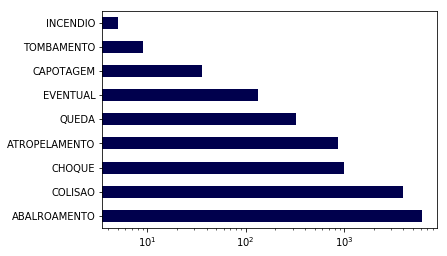

In [38]:
acident_type = acidents_data['TIPO_ACID'].value_counts()
acident_type.plot.barh(logx = True, color =(0,0,0.3))

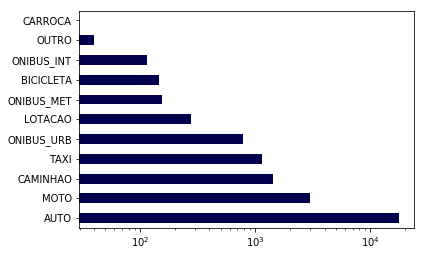

In [39]:
vehicle = acidents_data[[ 'AUTO', 'TAXI', 'LOTACAO', 'ONIBUS_URB', 'ONIBUS_MET', 'ONIBUS_INT',
       'CAMINHAO', 'MOTO', 'CARROCA', 'BICICLETA', 'OUTRO']].sum().sort_values(ascending=False)
vehicle.plot.barh(logx=True, color =(0,0,0.3))

 Analise temporal dos acidentes

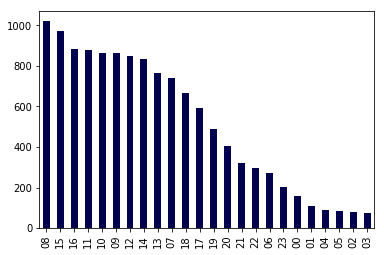

In [40]:
number_acidents_hour = acidents_data['HORA_ACID'].value_counts()
number_acidents_hour.plot.bar(color =(0,0,0.3))

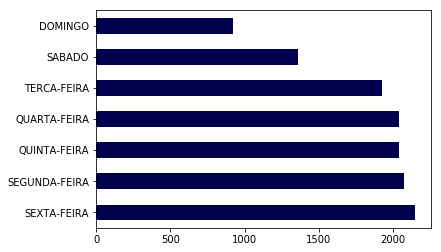

In [104]:
number_acidents_day = acidents_data['DIA_SEM'].value_counts()
number_acidents_day.plot.barh(color =(0,0,0.3))

In [138]:
%%opts Bars [width=700, height=400, xrotation=90, show_legend=False]
number_acidents_day = acidents_data.groupby(['DIA_SEM', 'HORA_ACID']).size()
number_acidents_day = number_acidents_day.reset_index(name = 'QTD_ACIDENT')
hist_coleta_lixo = hv.Bars(number_acidents_day, kdims=['DIA_SEM','HORA_ACID'], vdims='QTD_ACIDENT')
hist_coleta_lixo.groupby('DIA_SEM')

:HoloMap   [DIA_SEM]
   :Bars   [HORA_ACID]   (QTD_ACIDENT)

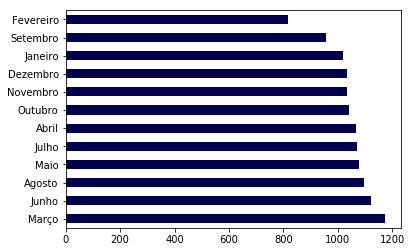

In [43]:
number_acidents_month = acidents_data['MES'].value_counts()
number_acidents_month.plot.barh(color =(0,0,0.3))

Analise de pessoas envolvidas nos acidentes por regiões

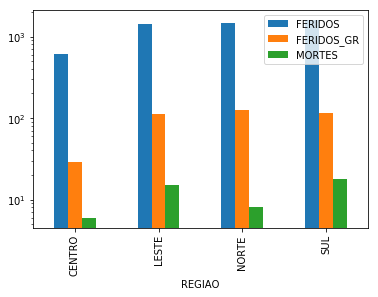

In [163]:
hurt_amount_region = acidents_data.groupby("REGIAO")[['FERIDOS', 'FERIDOS_GR', 'MORTES']].sum()
hurt_amount_region.drop(['NAO IDENTIFICADO']).plot.bar(logy=True)

### Hipótese: O Centro da cidade possui mais acidentes.

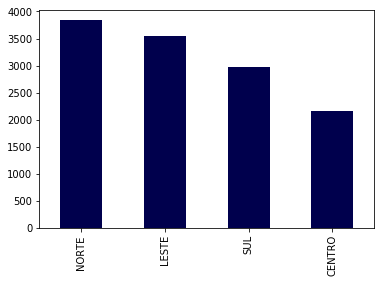

In [98]:
region_acidents = acidents_data['REGIAO'].value_counts()
region_acidents.drop(['NAO IDENTIFICADO']).plot.bar(color =(0,0,0.3))

### Hipótese: Existe uma relação entre a natureza do acidente com a quantidade de vítimas?

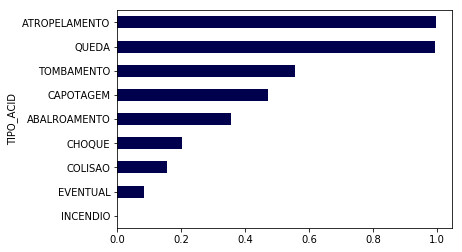

In [83]:
acident_type_vic = acidents_data.groupby("TIPO_ACID")['CONT_VIT'].mean().sort_values()
acident_type_vic.plot.barh(color =(0,0,0.3))

### Por que a maioria dos acidentes são em logradouros?

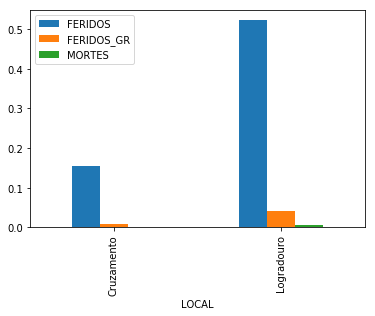

In [101]:
hurt_amount_region = acidents_data.groupby("LOCAL")[['FERIDOS', 'FERIDOS_GR', 'MORTES']].mean()
hurt_amount_region.plot.bar()

## Apredizagem

In [166]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [195]:
join_feridos_data = acidents_data[[ 'AUTO', 'TAXI', 'LOTACAO', 'ONIBUS_URB', 'ONIBUS_MET', 'ONIBUS_INT',
       'CAMINHAO', 'MOTO', 'CARROCA', 'BICICLETA', 'OUTRO', 'FERIDOS', 'FERIDOS_GR', 'MORTES']]
join_feridos_data['AFFECTED'] = join_feridos_data['FERIDOS'] + join_feridos_data['FERIDOS_GR'] + join_feridos_data['MORTES']
join_feridos_data

/home/jonatas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AUTO,TAXI,LOTACAO,ONIBUS_URB,ONIBUS_MET,ONIBUS_INT,CAMINHAO,MOTO,CARROCA,BICICLETA,OUTRO,FERIDOS,FERIDOS_GR,MORTES,AFFECTED
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1


In [213]:
join_feridos_data.corr()

,AUTO,TAXI,LOTACAO,ONIBUS_URB,ONIBUS_MET,ONIBUS_INT,CAMINHAO,MOTO,CARROCA,BICICLETA,OUTRO,FERIDOS,FERIDOS_GR,MORTES,AFFECTED
AUTO,1.000000,-0.212788,-0.118283,-0.250454,-0.111193,-0.069252,-0.251755,-0.460252,NaN,-0.096323,-0.040045,-0.335300,-0.152159,-0.048052,-0.345746
TAXI,-0.212788,1.000000,-0.007121,-0.040682,-0.023769,-0.020526,-0.061031,-0.116579,NaN,-0.015290,-0.012479,-0.093054,-0.025511,-0.009513,-0.091545
LOTACAO,-0.118283,-0.007121,1.000000,-0.020428,-0.016289,-0.014141,-0.034942,-0.052896,NaN,-0.000935,-0.008425,-0.036780,-0.004315,-0.008768,-0.035223
ONIBUS_URB,-0.250454,-0.040682,-0.020428,1.000000,0.000950,-0.010728,-0.043775,-0.087136,NaN,-0.006362,0.002812,0.022875,0.003739,0.010458,0.022609
ONIBUS_MET,-0.111193,-0.023769,-0.016289,0.000950,1.000000,-0.002988,-0.022676,-0.031352,NaN,0.008021,-0.006199,0.012716,-0.002850,0.015859,0.012260
ONIBUS_INT,-0.069252,-0.020526,-0.014141,-0.010728,-0.002988,1.000000,-0.025232,-0.035912,NaN,-0.002482,-0.005382,-0.027042,-0.011827,0.007482,-0.026768
CAMINHAO,-0.251755,-0.061031,-0.034942,-0.043775,-0.022676,-0.025232,1.000000,-0.139823,NaN,-0.023606,0.002006,-0.151129,-0.045041,-0.001258,-0.148296
MOTO,-0.460252,-0.116579,-0.052896,-0.087136,-0.031352,-0.035912,-0.139823,1.000000,NaN,-0.029115,-0.004673,0.483191,0.171326,0.022520,0.482426
CARROCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BICICLETA,-0.096323,-0.015290,-0.000935,-0.006362,0.008021,-0.002482,-0.023606,-0.029115,NaN,1.000000,-0.006088,0.097025,0.023648,0.016936,0.095355


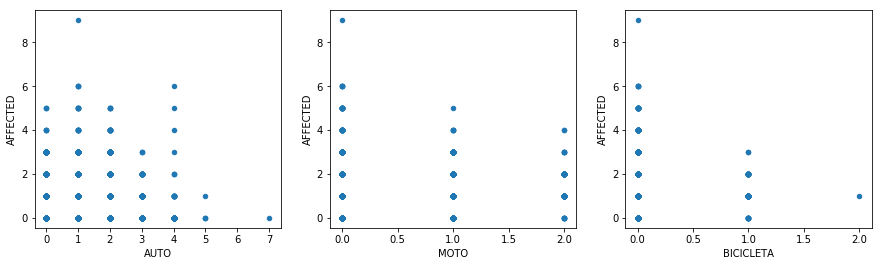

In [214]:
acidents_data[[ 'AUTO', 'TAXI', 'LOTACAO', 'ONIBUS_URB', 'ONIBUS_MET', 'ONIBUS_INT',
       'CAMINHAO', 'MOTO', 'CARROCA', 'BICICLETA', 'OUTRO']]
figs, axes = plt.subplots(1,3,figsize=(15,4))
join_feridos_data[['AUTO','AFFECTED']].plot.scatter(x='AUTO',y='AFFECTED',ax=axes[0])
join_feridos_data[['MOTO','AFFECTED']].plot.scatter(x='MOTO',y='AFFECTED',ax=axes[1])
join_feridos_data[['BICICLETA','AFFECTED']].plot.scatter(x='BICICLETA',y='AFFECTED',ax=axes[2]);

### Relação de feridos com Automóvel

In [198]:
model = smf.ols("FERIDOS ~ AUTO",data=join_feridos_data)
result = model.fit()
pd.concat([result.params,result.bse,result.tvalues,result.pvalues],
          axis=1, keys=['coef','SE','t','p-value'])

,coef,SE,t,p-value
Intercept,0.798580,0.011313,70.589547,0.0
AUTO,-0.281404,0.007068,-39.811800,0.0


In [207]:
from scipy.stats import linregress

X = join_feridos_data.AUTO.values.copy()
y = join_feridos_data.FERIDOS.values

model = linregress(X,y)
print('y = {:.3f} + {:.3f}x'.format(model.intercept,model.slope))
print('Stats')
print('r2 = {:.3f}, p-value={:.3f}'.format(model.rvalue**2,model.pvalue))

y = 0.799 + -0.281x
Stats
r2 = 0.112, p-value=0.000


### Relação de feridos com Moto

In [169]:
model = smf.ols("FERIDOS ~ MOTO",data=join_feridos_data)
result = model.fit()
pd.concat([result.params,result.bse,result.tvalues,result.pvalues],
          axis=1, keys=['coef','SE','t','p-value'])

,coef,SE,t,p-value
Intercept,0.235474,0.005793,40.647792,0.0
MOTO,0.716620,0.011608,61.735648,0.0


In [208]:
X = join_feridos_data.MOTO.values.copy()
y = join_feridos_data.FERIDOS.values

model = linregress(X,y)
print('y = {:.3f} + {:.3f}x'.format(model.intercept,model.slope))
print('Stats')
print('r2 = {:.3f}, p-value={:.3f}'.format(model.rvalue**2,model.pvalue))

y = 0.235 + 0.717x
Stats
r2 = 0.233, p-value=0.000


### Relação de feridos com Bicicleta

In [170]:
model = smf.ols("FERIDOS ~ BICICLETA",data=join_feridos_data)
result = model.fit()
pd.concat([result.params,result.bse,result.tvalues,result.pvalues],
          axis=1, keys=['coef','SE','t','p-value'])

,coef,SE,t,p-value
Intercept,0.397993,0.005834,68.218444,0.000000e+00
BICICLETA,0.587014,0.053831,10.904802,1.454508e-27


In [212]:
X = join_feridos_data.BICICLETA.values.copy()
y = join_feridos_data.FERIDOS.values

model = linregress(X,y)
print('y = {:.3f} + {:.3f}x'.format(model.intercept,model.slope))
print('Stats')
print('r2 = {:.3f}, p-value={:.3f}'.format(model.rvalue**2,model.pvalue))

y = 0.398 + 0.587x
Stats
r2 = 0.009, p-value=0.000


### Relação de feridos com Caminhão

In [225]:
model = smf.ols("FERIDOS ~ CAMINHAO",data=join_feridos_data)
result = model.fit()
pd.concat([result.params,result.bse,result.tvalues,result.pvalues],
          axis=1, keys=['coef','SE','t','p-value'])

,coef,SE,t,p-value
Intercept,0.438857,0.006096,71.993353,0.000000e+00
CAMINHAO,-0.300424,0.017567,-17.101907,7.818351e-65


In [223]:
model = smf.ols("AFFECTED ~ AUTO + TAXI + LOTACAO + ONIBUS_URB + ONIBUS_MET + ONIBUS_INT + CAMINHAO + MOTO + CARROCA + BICICLETA + OUTRO",data=join_feridos_data)
result = model.fit()

In [224]:
pd.concat([result.params,result.bse,result.tvalues,result.pvalues],
          axis=1, keys=['coef','SE','t','p-value'])

,coef,SE,t,p-value
Intercept,8.346276e-01,2.242685e-02,37.215559,1.334475e-287
AUTO,-2.916176e-01,1.083011e-02,-26.926550,2.745310e-155
TAXI,-3.398490e-01,2.055459e-02,-16.533966,9.210769e-61
LOTACAO,-3.287005e-01,3.793544e-02,-8.664736,5.078296e-18
ONIBUS_URB,-1.391458e-01,2.495109e-02,-5.576743,2.501466e-08
ONIBUS_MET,-1.508948e-01,4.923554e-02,-3.064753,2.183137e-03
ONIBUS_INT,-3.581970e-01,5.714924e-02,-6.267747,3.783505e-10
CAMINHAO,-4.404322e-01,1.942255e-02,-22.676337,1.344410e-111
MOTO,4.644621e-01,1.709528e-02,27.169034,5.546064e-158
CARROCA,7.975180e-16,7.644233e-17,10.432937,2.229157e-25
